In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from google.colab import files
import joblib

# STEP 1: Load dataset
df = pd.read_csv("final_merged_STL_PCA_dataset.csv")
df["date"] = pd.to_datetime(df["date"])

# Drop 'date' column, keep all features including target (Egg_price)
data = df.drop(columns=["date"])

# STEP 2: Normalize features
scaler = MinMaxScaler()
normalized = scaler.fit_transform(data)
normalized_df = pd.DataFrame(normalized, columns=data.columns)

# Save scaler for inverse transformation later
joblib.dump(scaler, "scaler.pkl")

# STEP 3: Sliding window parameters
N = 30  # Number of past days (input window size)
M = 7   # Number of future days to predict (output window size)

# STEP 4: Create sliding windows
X, y = [], []
for i in range(len(normalized_df) - N - M + 1):
    # Input features: All variables (Egg_price, Trend, Seasonal, Residual, F1, F2, F3)
    X.append(normalized_df.iloc[i : i+N].values)
    # Target: Future Egg_price only
    y.append(normalized_df["Egg_price"].iloc[i+N : i+N+M].values)

X = np.array(X)
y = np.array(y)

print("✅ Total samples created:", len(X))
print("✅ Input shape:", X.shape)
print("✅ Output shape:", y.shape)

# STEP 5: Train-test split (80:20)
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")

# STEP 6: Save arrays
np.save("X_train.npy", X_train)
np.save("y_train.npy", y_train)
np.save("X_test.npy", X_test)
np.save("y_test.npy", y_test)

# Download files
files.download("X_train.npy")
files.download("y_train.npy")
files.download("X_test.npy")
files.download("y_test.npy")
files.download("scaler.pkl")


/tmp/ipython-input-3936285378.py:8: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("final_merged_STL_PCA_dataset.csv")


✅ Total samples created: 354728
✅ Input shape: (354728, 30, 7)
✅ Output shape: (354728, 7)
Train samples: 283782, Test samples: 70946


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Data Loaded
X_train: (283782, 30, 7) y_train: (283782, 7, 1)
X_test: (70946, 30, 7) y_test: (70946, 7, 1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
8869/8869 ━━━━━━━━━━━━━━━━━━━━ 78s 8ms/step - loss: 0.0074 - mae: 0.0199 - val_loss: 3.6128e-04 - val_mae: 0.0103
Epoch 2/1000
8869/8869 ━━━━━━━━━━━━━━━━━━━━ 71s 8ms/step - loss: 5.3842e-04 - mae: 0.0097 - val_loss: 6.6971e-04 - val_mae: 0.0074
Epoch 3/1000
8869/8869 ━━━━━━━━━━━━━━━━━━━━ 86s 8ms/step - loss: 0.0029 - mae: 0.0125 - val_loss: 2.2570e-04 - val_mae: 0.0029
Epoch 4/1000
8869/8869 ━━━━━━━━━━━━━━━━━━━━ 80s 8ms/step - loss: 0.0032 - mae: 0.0141 - val_loss: 0.0023 - val_mae: 0.0082
Epoch 5/1000
8869/8869 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - loss: 0.0011 - mae: 0.0154 - val_loss: 5.0242e-04 - val_mae: 0.0153
Epoch 6/1000
8869/8869 ━━━━━━━━━━━━━━━━━━━━ 85s 9ms/step - loss: 0.0032 - mae: 0.0162 - val_loss: 3.7709e-04 - val_mae: 0.0095
Epoch 7/1000
8869/8869 ━━━━━━━━━━━━━━━━━━━━ 72s 8ms/step - loss: 7.2064e-04 - mae: 0.0120 - val_loss: 2.9946e-04 - val_mae: 0.0067
Epoch 8/1000
8869/8869 ━━━━━━━━━━━━━━━━━━━━ 84s 8ms/step - loss: 5.8147e-04 - mae: 0.0110 - val_loss: 2.117

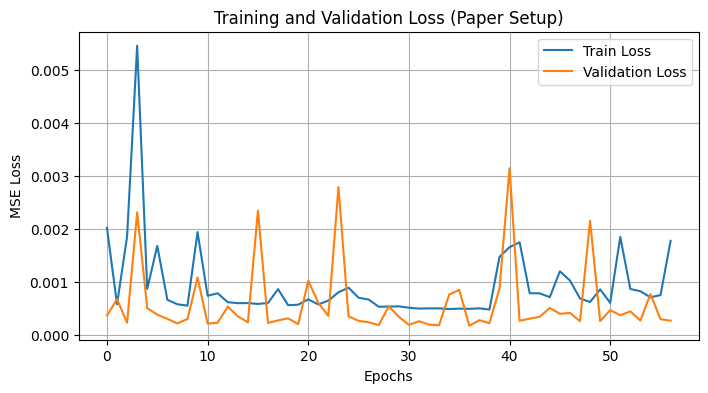

✅ Model saved as 'gru_seq2seq_model_paper.h5'


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt

# STEP 1: Load the data
X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")

# STEP 2: Reshape y to 3D (samples, M, 1)
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], 1))

print("✅ Data Loaded")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

# STEP 3: Define GRU Seq2Seq model (Paper Setup)
model = Sequential([
    GRU(
        64,
        activation='tanh',
        input_shape=(X_train.shape[1], X_train.shape[2]),
        return_sequences=False,
        kernel_regularizer=regularizers.l2(0.003)
    ),
    RepeatVector(y_train.shape[1]),
    GRU(
        64,
        activation='tanh',
        return_sequences=True,
        kernel_regularizer=regularizers.l2(0.003)
    ),
    TimeDistributed(Dense(1))
])

# Optimizer with LR=0.01
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, clipnorm=2.5)  # Gradient clipping threshold = 2.5

model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# STEP 4: Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=1000,       # Paper used 1000 iterations
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# STEP 5: Evaluate model
loss, mae = model.evaluate(X_test, y_test, verbose=1)
print(f"✅ Test Loss (MSE): {loss:.4f}")
print(f"✅ Test MAE: {mae:.4f}")

# STEP 6: Plot training history
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss (Paper Setup)")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()

# STEP 7: Save model
model.save("gru_seq2seq_model_paper.h5")
print("✅ Model saved as 'gru_seq2seq_model_paper.h5'")


2218/2218 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step
📊 Model Evaluation Metrics:
MAE   : 0.5490
RMSE  : 0.8890
MAPE  : 0.15%
R²    : 0.9986


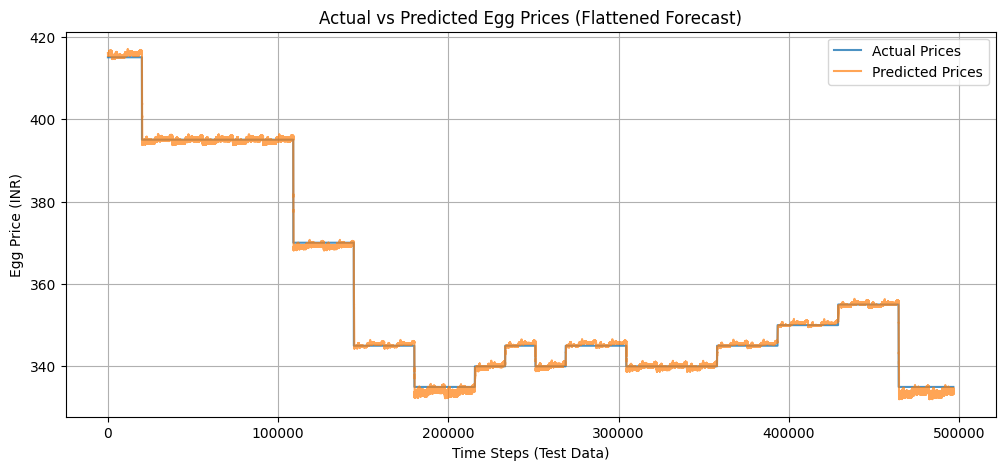

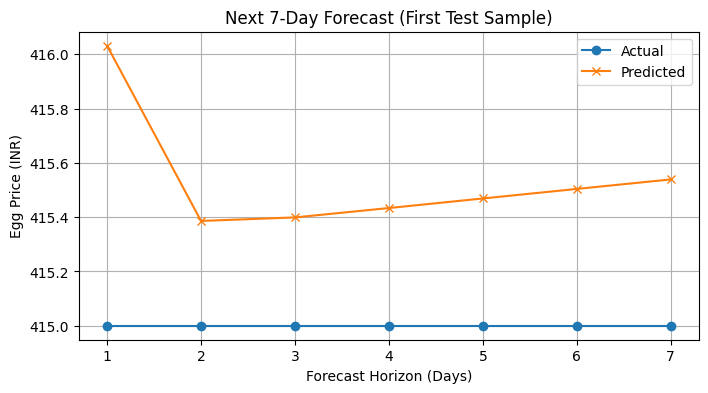

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import joblib
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# -------------------------------
# STEP 1: Load data
# -------------------------------
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")

# Reshape y for predictions
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], 1))

# -------------------------------
# STEP 2: Load model with fix
# -------------------------------
model = load_model("gru_seq2seq_model_paper.h5", compile=False)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01, clipnorm=2.5),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=['mae']
)

# Load scaler
scaler = joblib.load("scaler.pkl")

# -------------------------------
# STEP 3: Predict
# -------------------------------
y_pred = model.predict(X_test)

# -------------------------------
# STEP 4: Inverse transform
# -------------------------------
def inverse_egg_price(scaled_values):
    dummy = np.zeros((scaled_values.shape[0], scaler.n_features_in_))
    dummy[:, 0] = scaled_values
    return scaler.inverse_transform(dummy)[:, 0]

# Flatten predictions for metrics
y_test_flat = y_test.reshape(-1)
y_pred_flat = y_pred.reshape(-1)

y_test_inv = inverse_egg_price(y_test_flat)
y_pred_inv = inverse_egg_price(y_pred_flat)

# -------------------------------
# STEP 5: Metrics calculation
# -------------------------------
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100
r2 = r2_score(y_test_inv, y_pred_inv)

print("📊 Model Evaluation Metrics:")
print(f"MAE   : {mae:.4f}")
print(f"RMSE  : {rmse:.4f}")
print(f"MAPE  : {mape:.2f}%")
print(f"R²    : {r2:.4f}")

# -------------------------------
# STEP 6: Visualization
# -------------------------------

# 1️⃣ Flattened Actual vs Predicted
plt.figure(figsize=(12,5))
plt.plot(y_test_inv, label="Actual Prices", alpha=0.8)
plt.plot(y_pred_inv, label="Predicted Prices", alpha=0.7)
plt.title("Actual vs Predicted Egg Prices (Flattened Forecast)")
plt.xlabel("Time Steps (Test Data)")
plt.ylabel("Egg Price (INR)")
plt.legend()
plt.grid(True)
plt.show()

# 2️⃣ Plot first test sample's forecast (7-day horizon)
y_test_seq = y_test.reshape(y_test.shape[0], y_test.shape[1])
y_pred_seq = y_pred.reshape(y_pred.shape[0], y_pred.shape[1])

y_test_seq_inv = inverse_egg_price(y_test_seq[0])
y_pred_seq_inv = inverse_egg_price(y_pred_seq[0])

plt.figure(figsize=(8,4))
plt.plot(range(1, len(y_test_seq_inv)+1), y_test_seq_inv, marker='o', label="Actual")
plt.plot(range(1, len(y_pred_seq_inv)+1), y_pred_seq_inv, marker='x', label="Predicted")
plt.title("Next 7-Day Forecast (First Test Sample)")
plt.xlabel("Forecast Horizon (Days)")
plt.ylabel("Egg Price (INR)")
plt.legend()
plt.grid(True)
plt.show()


Saving merged_egg_model_data.csv to merged_egg_model_data.csv
📊 Pearson Correlation with Egg Price:
egg_price              1.000000
cpi_eggs               0.710896
cpi_foodbev            0.669094
cpi_meatfish           0.611874
hyderabad_price        0.549950
maize_price            0.450407
namakkal_price         0.374101
shravan_intensity      0.108867
birdflu_demandpanic   -0.079712
soymeal_price         -0.112578
birdflu_supplyshock         NaN
Name: egg_price, dtype: float64


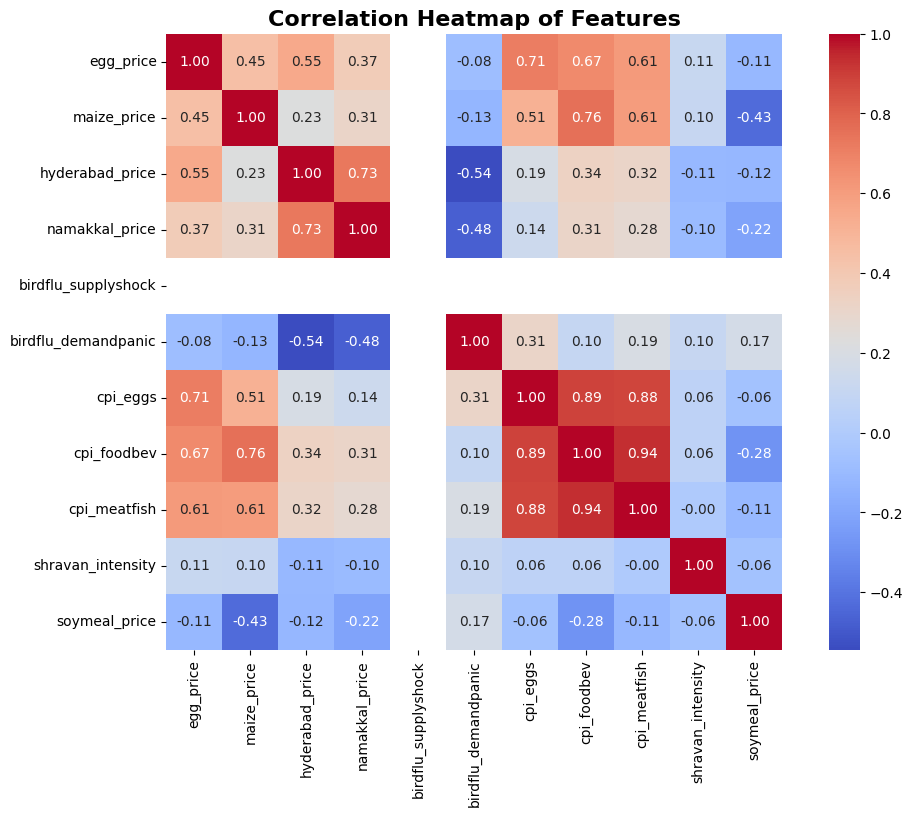

In [ ]:
# =========================================
# STEP 1: Install & Import Libraries
# =========================================
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files

# =========================================
# STEP 2: Upload CSV File
# =========================================
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Load the dataset
df = pd.read_csv(filename)

# =========================================
# STEP 3: Data Preparation
# =========================================
# Convert 'date' column to datetime if not already
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Drop non-numeric columns (keeping only numerical features for correlation)
df_numeric = df.drop(columns=['date'])

# =========================================
# STEP 4: Compute Correlation Matrix
# =========================================
corr_matrix = df_numeric.corr(method='pearson')

# Display correlation with egg_price sorted
print("📊 Pearson Correlation with Egg Price:")
print(corr_matrix['egg_price'].sort_values(ascending=False))

# =========================================
# STEP 5: Generate Heatmap
# =========================================
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap of Features", fontsize=16, fontweight='bold')
plt.show()
